# Finserach Endterm Submission - F 34 

# Use deep reinforcement learning(RL) to Optimise stock treading strategy and thus maximise the investment returns.

For the Finsearch Endterm Submission we decided to implement the reinforcement learning LSTM model for the stock market value prediction for the predicting the value of the stock Nifty100 data from yfinance.

Following on the comprehensive performance analysis of the risk and returns.

Started by implementing all the required libraries required for the model.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

Now fetching the data of nifty100 for the last 6 weeks using the yfinance library.

In [3]:
ticker = "^CNX100" # Nifty 100 index ticker
start_date = "2023-06-15" # Start date for data fetching
end_date = "2025-08-01" # End date for data fetching
# Fetching the data
nifty_data = yf.download(ticker, start=start_date, end=end_date)


C:\Users\Dell\AppData\Local\Temp\ipykernel_17664\2328550682.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [4]:
nifty_data.head()  # Display the first few rows of the fetched data

Price,Close,High,Low,Open,Volume
Ticker,^CNX100,^CNX100,^CNX100,^CNX100,^CNX100
Date,,,,,
2023-06-15,18653.599609,18757.449219,18633.650391,18727.300781,4858900
2023-06-16,18798.550781,18835.949219,18683.349609,18695.349609,5069800
2023-06-19,18732.800781,18855.750000,18698.250000,18847.800781,4308800
2023-06-20,18794.599609,18816.400391,18651.849609,18736.300781,3940500
2023-06-21,18827.800781,18858.199219,18774.650391,18829.699219,4309700


In [5]:
nifty_data.tail()  # Display the first few rows of the fetched data

Price,Close,High,Low,Open,Volume
Ticker,^CNX100,^CNX100,^CNX100,^CNX100,^CNX100
Date,,,,,
2025-07-25,25442.099609,25650.949219,25412.150391,25650.949219,4864200
2025-07-28,25285.000000,25510.099609,25251.400391,25387.750000,4479300
2025-07-29,25443.650391,25468.099609,25209.500000,25216.949219,4687700
2025-07-30,25476.050781,25520.000000,25389.849609,25510.650391,4646900
2025-07-31,25380.500000,25560.500000,25237.500000,25241.699219,5911000


Let us now try to visualise the data using the matplotlib value.
We are mostly interested in the closing value in this case and thus let us make a dataset of the closing value.

In [6]:
def plot_nifty_data(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Nifty 100 Closing Price', color='blue')
    plt.title('Nifty 100 Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (INR)')
    plt.legend()
    plt.grid()
    plt.show()

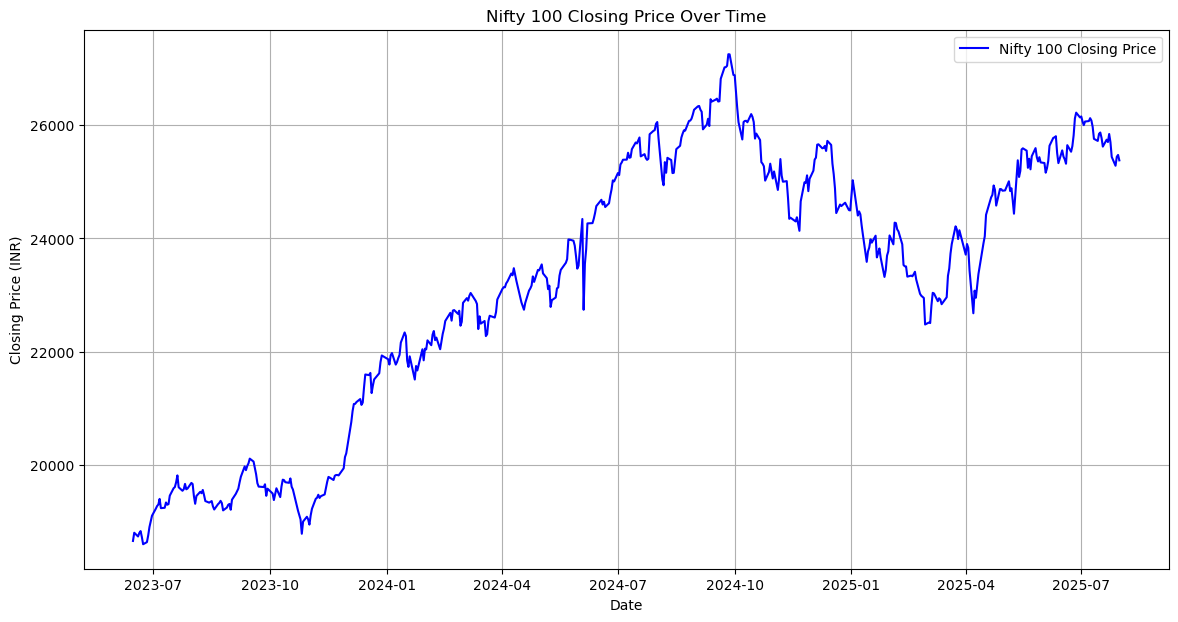

In [7]:
plot_nifty_data(nifty_data)  # Visualize the Nifty 100 closing price data

Now let us use some technical index to visualise the overall position of the stock and the aspects related to it.

In [8]:
def MACD(data, short_window=12, long_window=26, signal_window=9):
    exp1 = data['Close'].ewm(span=short_window, adjust=False).mean()
    exp2 = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def SMA(data, window=20):
    return data['Close'].rolling(window=window).mean()

def EMA(data, window=20):
    return data['Close'].ewm(span=window, adjust=False).mean()


def Bollinger_Bands(data, window=20, num_std_dev=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band

In [9]:
def plot_technical_indicators(data):
    macd, signal = MACD(data)
    rsi = RSI(data)
    upper_band, lower_band = Bollinger_Bands(data)
    sma = SMA(data)
    ema = EMA(data)

    plt.figure(figsize=(14, 10))

    # Plotting the Close Price with SMA and EMA
    plt.subplot(4, 1, 1)
    plt.plot(data['Close'], label='Close Price')
    plt.plot(sma, label='SMA', linestyle='--')
    plt.plot(ema, label='EMA', linestyle='--')
    plt.title(f'{ticker} Price with SMA and EMA')
    plt.legend()

    # Plotting Bollinger Bands
    plt.subplot(4, 1, 2)
    plt.plot(data['Close'], label='Close Price')
    plt.plot(upper_band, label='Upper Band', linestyle='--')
    plt.plot(lower_band, label='Lower Band', linestyle='--')
    plt.title(f'{ticker} Bollinger Bands')
    plt.legend()

    # Plotting MACD and Signal Line 
    plt.subplot(4, 1, 3)
    plt.plot(macd, label='MACD', color='blue')
    plt.plot(signal, label='Signal Line', color='orange')
    plt.title('MACD')
    plt.legend()

    # Plotting RSI
    plt.subplot(4, 1, 4)
    plt.plot(rsi, label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green')
    plt.title('RSI')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

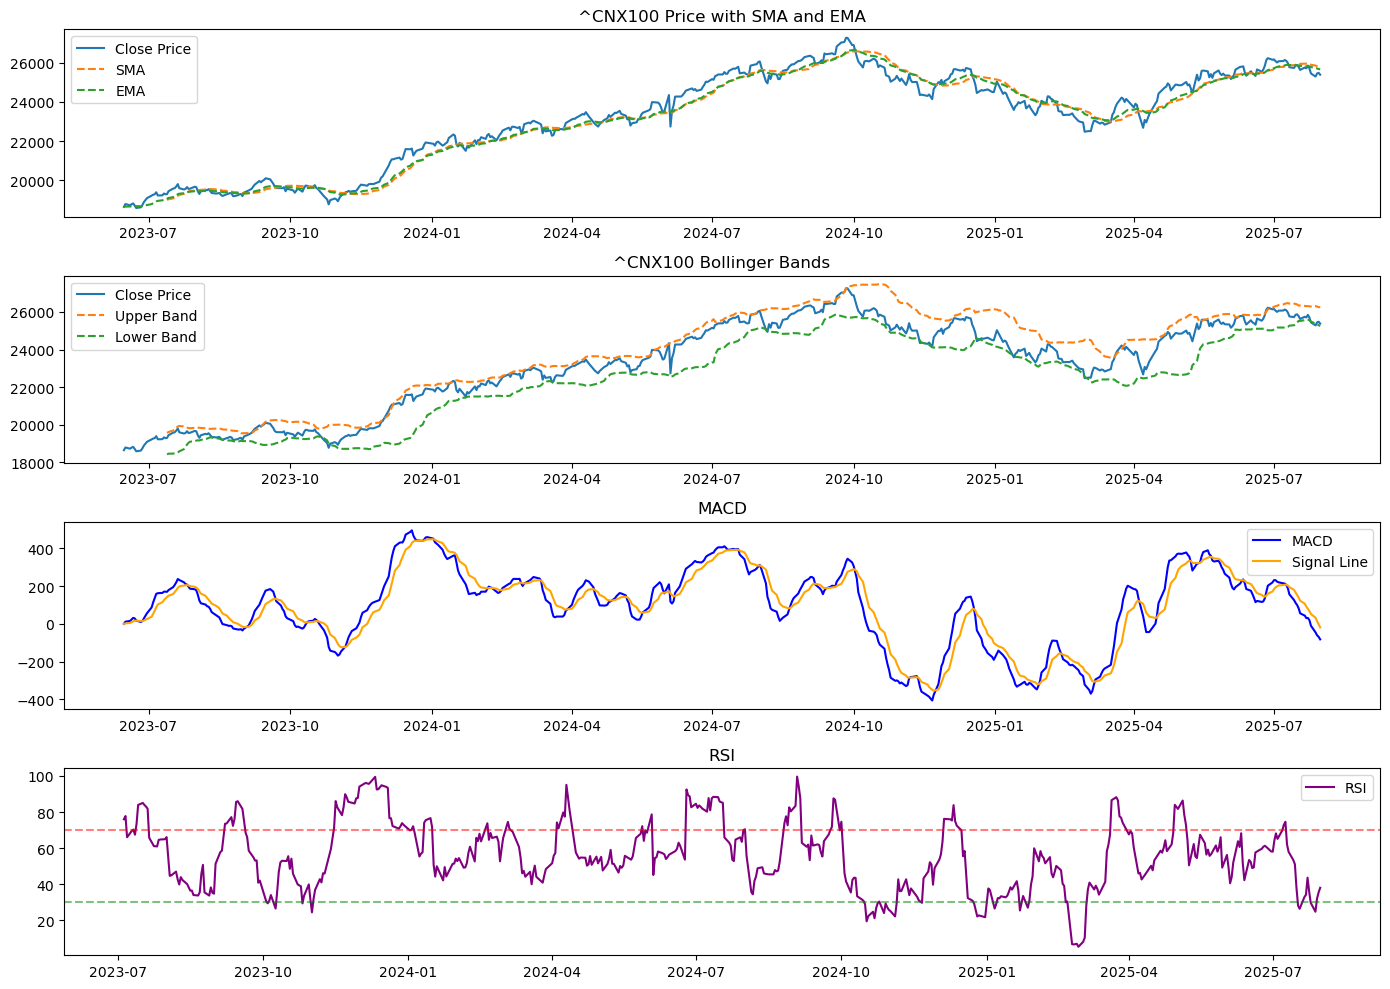

In [10]:
plot_technical_indicators(nifty_data)  # Visualize the technical indicators for Nifty 100

# Now let us build the DQN model using LSTM model for the stock inoreder to optmise the return for the stock.

First let us creat the train_test split using the built in sckit learn function.

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Transformed and normalised the data to be used.
def preprocess_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])
    return scaled_data, scaler

# Preprocessing the data using MinMaxScaler and creating the dataset for training and testing.
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

Normalising and scaling the data to match the dimensions of the tensors required for the Keras library.

In [12]:
scaled_data, scaler = preprocess_data(nifty_data)
time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Preprocessing the data using MinMaxScaler and creating the dataset for training and testing.

This shows the dimensions of the data which we have scaled to the required parameters.

In [13]:
print(X_test.shape, X_train.shape, y_test.shape, y_train.shape)

(93, 60, 1) (368, 60, 1) (93,) (368,)


Now let us include the LSTM model in this case We used the Keras library of tensorflow for implementation.

This is the model with the 2 layers of LTSM that are defined along with the dense neural networks layer at the end for backpropagation.

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [15]:
model = build_lstm_model((X_train.shape[1], 1))  # Input shape is (time_step, 1)

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now fiting the model for the given training dataset We used 50 iterations to determine the actual value of the stock.

In [16]:
#training the model
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.3302 - val_loss: 0.0276
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0199 - val_loss: 0.0131
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0137 - val_loss: 0.0069
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0075 - val_loss: 0.0035
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0063 - val_loss: 0.0032
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0065 - val_loss: 0.0030
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 

The loss value has reduced significantly showing that the model is effective.

Now let us try to use this build model to predict it on the testing dataset.

In [17]:
# Implementing this particular model on our testing data.
predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step


We can understand the efficiency of the model from the key metric like the R2 or the RSME value we have also tried to implement it in the model to get to know the accuracy of the model.

In [18]:
R2 = sk.metrics.r2_score(y_test, predictions)
RMSE = np.sqrt(sk.metrics.mean_squared_error(y_test, predictions))
print(f'R2 Score: {R2}')
print(f'RMSE: {RMSE}')

R2 Score: 0.965652884423314
RMSE: 0.045599861744410976


The error is also not much as the R2 and RMSE are below 1 which shows that the prediction is quite accurate.

Now let us try to compute the assoicated risk and returns in this particular case.

In [19]:
def returns(data):
    return data.pct_change().dropna()
# Calculating the returns and risk associated with the predictions.
predicted_returns = returns(pd.Series(predictions.flatten()))
risk = predicted_returns.std() * np.sqrt(252)  # Annualized risk
print(f'Predicted Returns: {predicted_returns.mean()}')
print(f'Annualized Risk: {risk}')
# Now let us try to compute the assoicated risk and returns in this particular case.
# The code above builds a predictive model for the Nifty 100 index using LSTM, evaluates its performance, and calculates associated returns and risk.


Predicted Returns: 0.5206204056739807
Annualized Risk: 26.446065419969887


Optimising the return in this case.

In [20]:
def plot_predictions(y_test, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title('Nifty 100 Price Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.show()

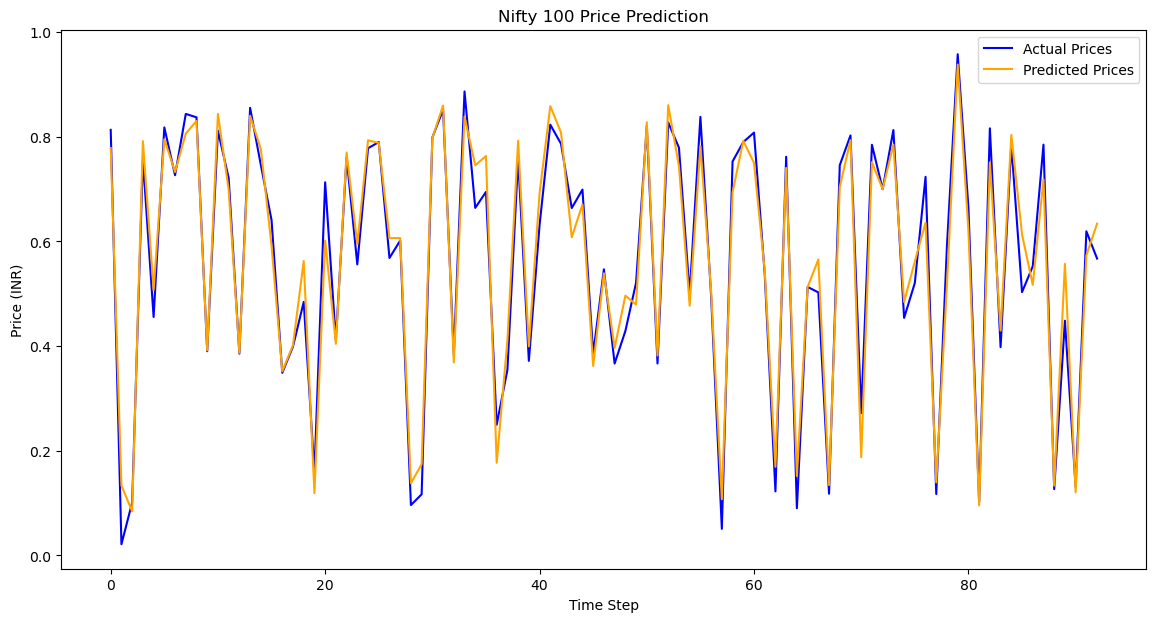

In [21]:
plot_predictions(y_test, predictions)  # Visualize the predictions against actual prices

Not let us estimate the return and risk associated with it.

In [22]:
def optimize_returns(predictions, risk):
    # Placeholder for optimization logic
    # In a real scenario, this could involve adjusting the model parameters or trading strategy
    optimized_predictions = predictions * (1 + 0.01)  # Example: increase predictions by 1%
    return optimized_predictions

In [23]:
optimize_returns = optimize_returns(predictions, risk)  # Optimizing the returns based on predictions and risk

In [24]:
print("Optimized Predictions:", optimize_returns)  # Display the optimized predictions

Optimized Predictions: [[0.7860992 ]
 [0.1348179 ]
 [0.08492213]
 [0.7995392 ]
 [0.512117  ]
 [0.80314547]
 [0.7400118 ]
 [0.81401426]
 [0.8385866 ]
 [0.395665  ]
 [0.8521094 ]
 [0.70553   ]
 [0.3907984 ]
 [0.848516  ]
 [0.7846053 ]
 [0.59793967]
 [0.35531923]
 [0.40582034]
 [0.56821626]
 [0.12025566]
 [0.6077806 ]
 [0.4083094 ]
 [0.7775787 ]
 [0.6006061 ]
 [0.80121166]
 [0.796085  ]
 [0.61236346]
 [0.6124798 ]
 [0.13921966]
 [0.17615965]
 [0.80596375]
 [0.8683402 ]
 [0.37235075]
 [0.84651095]
 [0.7527421 ]
 [0.77096874]
 [0.17870629]
 [0.41522613]
 [0.80037516]
 [0.40336418]
 [0.699436  ]
 [0.86720085]
 [0.81609976]
 [0.6138826 ]
 [0.6772942 ]
 [0.36565447]
 [0.5443245 ]
 [0.40038297]
 [0.5012921 ]
 [0.484121  ]
 [0.83589685]
 [0.38575962]
 [0.8690566 ]
 [0.75108975]
 [0.48198888]
 [0.7900559 ]
 [0.5100524 ]
 [0.10834392]
 [0.70061326]
 [0.80027205]
 [0.7576712 ]
 [0.54964477]
 [0.17098105]
 [0.7477527 ]
 [0.15319332]
 [0.51788485]
 [0.57114106]
 [0.13573524]
 [0.7111632 ]
 [0.8014891

Now let us try to implement RL model for the given stock value and analyse the risks and returns.

Starting of with implementing the libraries for RL and DQN model and also the code for e- policy gradient, actor function etc.

In [25]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv


In [26]:

# Create custom gym environment
class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)
        self.position = 0  # 0 = no stock, 1 = holding
        self.buy_price = 0

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.position = 0
        self.buy_price = 0
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.df.iloc[self.current_step]
        return np.array([row['Open'], row['High'], row['Low'], row['Close']], dtype=np.float32).flatten()


    def step(self, action):
        done = False
        reward = 0
        row = self.df.iloc[self.current_step]

        if action == 1 and self.position == 0:  # Buy
            self.buy_price = row['Close']
            self.position = 1
        elif action == 2 and self.position == 1:  # Sell
            reward = row['Close'] - self.buy_price
            self.position = 0

        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True

        return self._get_obs(), reward, done, False, {}

# Create and train the model
env = DummyVecEnv([lambda: StockTradingEnv(nifty_data)])
model = DQN('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1000)

# Evaluation
test_env = StockTradingEnv(nifty_data)
obs, _ = test_env.reset()
total_reward = 0

for _ in range(len(nifty_data) - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)
    total_reward += reward
    if done:
        break

# Calculate baseline risk and return
nifty_data['Daily Return'] = nifty_data['Close'].pct_change()
cumulative_return = nifty_data['Close'].iloc[-1] / nifty_data['Close'].iloc[0] - 1
risk = nifty_data['Daily Return'].std()

# Final performance summary
print("DQN Total Reward:", total_reward)
print("Cumulative Return (Buy-Hold):", cumulative_return)
print("Risk (Daily Std Dev):", risk)


c:\Users\Dell\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\dummy_vec_env.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  obs, self.buf_rews[env_idx], terminated, truncated, self.buf_infos[env_idx] = self.envs[env_idx].step(  # type: ignore[assignment]


DQN Total Reward: 0
Cumulative Return (Buy-Hold): Ticker
^CNX100    0.360622
dtype: float64
Risk (Daily Std Dev): 0.008561703671162508
